# Concrete Compressive Strength
Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. These ingredients include cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LassoCV, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as MSE

## 1. Import and clean data

In [4]:
xls = pd.ExcelFile('data/Concrete_Data.xls')

In [5]:
xls.sheet_names

['Sheet1', 'Sheet2', 'Sheet3']

In [6]:
names = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_agg', 'fine_agg', 'age',\
 'concrete_compressive_strength']

In [7]:
df = xls.parse(0, names = names)
df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


### 1.1 Data Inspection

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_agg                     1030 non-null   float64
 6   fine_agg                       1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [10]:
print('The dataset contains {} rows and {} Features.'.format(df.shape[0], df.shape[1]))
print('All features are numeric including the target')
print('It contains 8 numercial features and a target, and there are no missing values in any column or row.')
print('There are {} duplicates present in the dataset'.format(df.duplicated().sum()))

The dataset contains 1030 rows and 9 Features.
All features are numeric including the target
It contains 8 numercial features and a target, and there are no missing values in any column or row.
There are 25 duplicates present in the dataset


In [11]:
df[df.duplicated()].head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,concrete_compressive_strength
77,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217
80,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217
86,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.301171
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.301171
91,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.301171


In [12]:
df = df.drop_duplicates(keep ='first')

In [13]:
print(f'The dataset no longer contain duplicates and the rows are {df.shape[0]}, after dropping the duplicates')

The dataset no longer contain duplicates and the rows are 1005, after dropping the duplicates


## 1.1.1 Quick view at the target

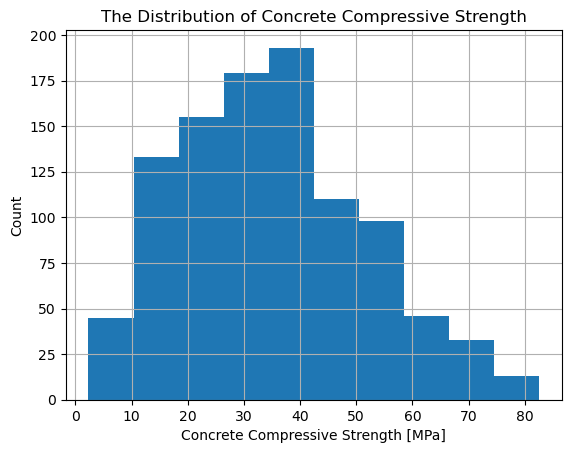

In [15]:
df['concrete_compressive_strength'].hist()
plt.xlabel('Concrete Compressive Strength [MPa]')
plt.ylabel('Count')
plt.title('The Distribution of Concrete Compressive Strength');

## 2. Exploratory Data Analysis

### 2.1 Distribution of Features

In [18]:
df.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,concrete_compressive_strength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.629055,72.043134,55.535075,182.074378,6.031647,974.376468,772.686617,45.856716,35.250273
std,104.345003,86.170555,64.207448,21.340740,5.919559,77.579534,80.339851,63.734692,16.284808
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,190.680000,0.000000,0.000000,166.610000,0.000000,932.000000,724.300000,7.000000,23.523542
50%,265.000000,20.000000,0.000000,185.700000,6.100000,968.000000,780.000000,28.000000,33.798114
75%,349.000000,142.500000,118.270000,192.940000,10.000000,1031.000000,822.200000,56.000000,44.868340
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


### Insights
- The average value of concrete compressive strength is 35MPa, although most of the concretes' strength are below the mean(35)

In [20]:
continuous = df.loc[:, df.columns[df.dtypes == 'float']]
discrete = df['age']

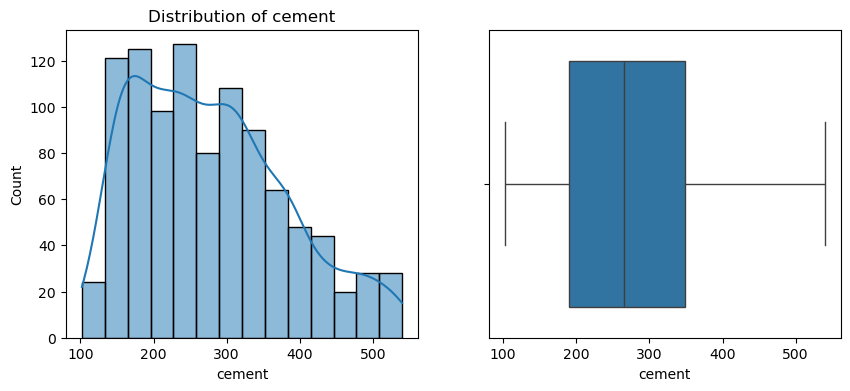

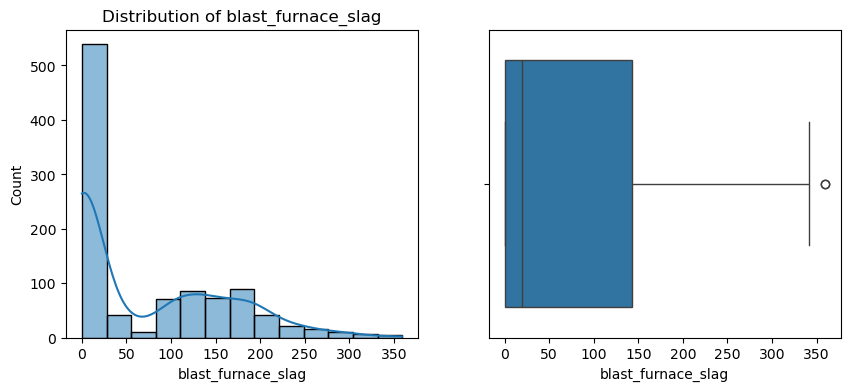

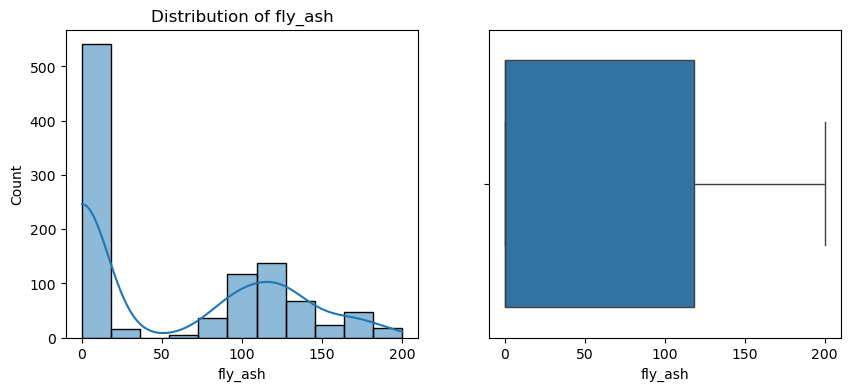

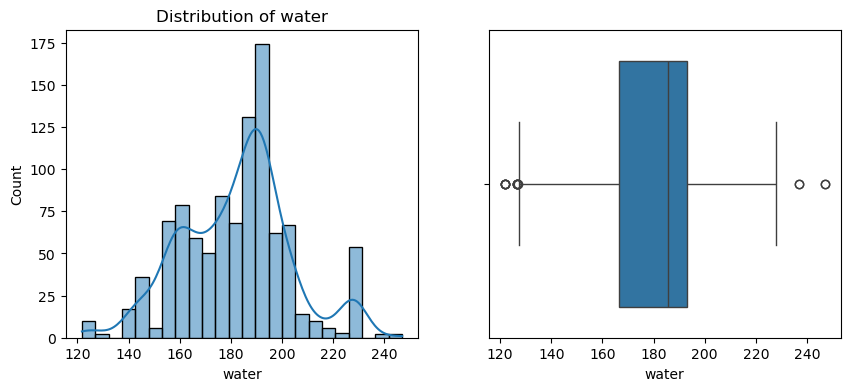

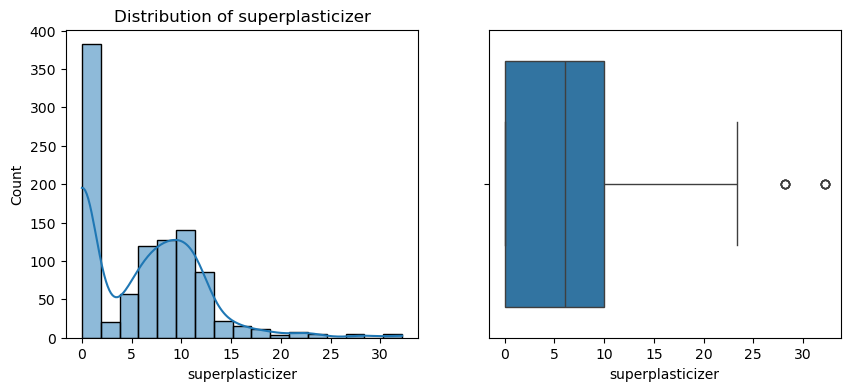

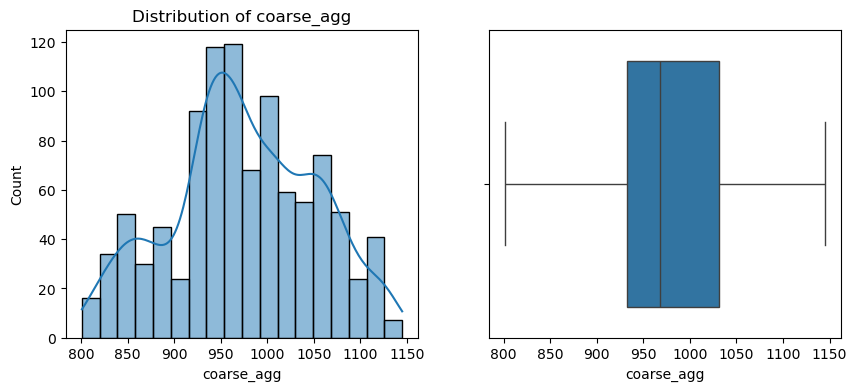

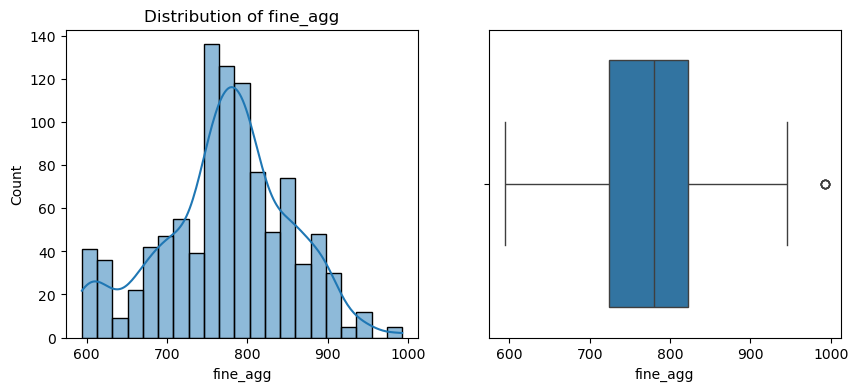

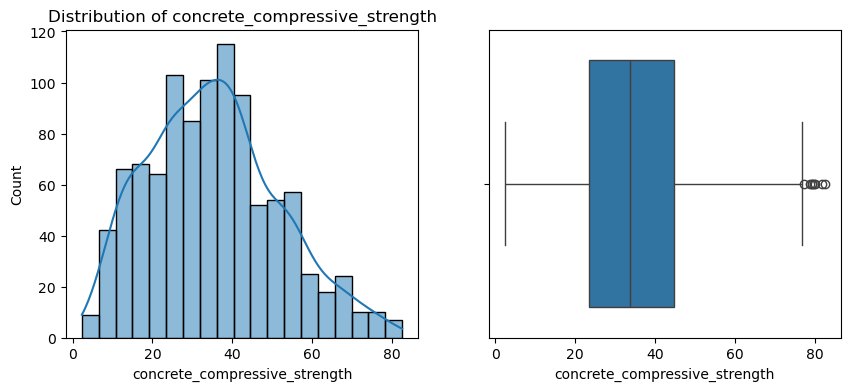

In [21]:
for feature in continuous:
    fig, ax = plt.subplots(1,2, figsize =(10, 4))
    sns.histplot(data = continuous, kde = True, x = feature, ax = ax[0])
    ax[0].set_title('Distribution of {}'.format(continuous[feature].name))
    sns.boxplot(data = continuous, x = feature, ax = ax[1])
    

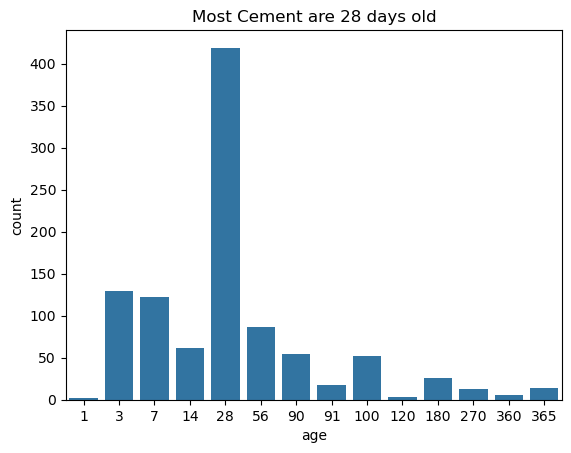

In [22]:
sns.countplot(x='age', data = df)
plt.title('Most Cement are 28 days old');

### Insights
1. **blast furnace slag**, **fly ash**, and **superplasticizer** are largely skewed
2. Only few cements contain greater than 200kg/m3 blast furnace slag
3. most of the cement contain less than 50kg/m3 fly ash
4. Most of the concrete contain less than 13kg/m3 superplasticizer, we very few contain more than 30 
5. vast mjority of the cement are 28 days old 

### 2.2 Transform Features with Outliers

In [332]:
features_with_outliers = ['blast_furnace_slag','fly_ash', 'superplasticizer']

In [59]:
_, l = stats.yeojohnson(df['fly_ash'])

In [61]:
l

-0.10916658840978022

In [63]:
# _, l = boxcox(df['blast_furnace_slag'])

Observation
- Cement is moderately correlated with the the target- concrete compressive strength
- There is also a slight positive relationship between superplasticizer and fly ash 
- there is a slightly strong negative correlation between superplasticizer and water, likewise a slight one between water and fine aggregrate